<a href="https://colab.research.google.com/github/marcosbaccin/Agrupamento_de_clientes/blob/main/Kmeans_Agrupamentos_de_Clientes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1° Problema de Negócio
Precisamos construir uma Máquina Preditiva que, a partir de dados de consumo de energia de clientes, agrupe os consumidores por similaridade, afim de compreender o comportamento dos clientes e sua relação com o consumo de energia.



# 2° Análise Exploratória dos Dados

### Fonte de Dados
https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption


Medidas de consumo de energia elétrica em uma residência com uma taxa de amostragem de um minuto durante um período de quase 4 anos. Diferentes grandezas elétricas e alguns valores de submedição estão disponíveis.




### AD (Arquitetura de Dados/Dicionário de Dados):

1. **data**: Data no formato dd / mm / aaaa
2. **hora**: hora no formato hh: mm: ss
3. **global_active_power**: potência ativa média global por minuto (em quilowatt)
4. **potência reativa global da família**: potência reativa média global por minuto (em quilowatt)
5. **voltagem**: tensão média por minuto (em volt)
6. **intensidade global**: intensidade de corrente média por minuto global doméstica (em ampere)
7. **sub_metering_1**: submedição de energia nº 1 (em watt-hora de energia ativa ) Corresponde à **cozinha**, que contém essencialmente uma máquina de lavar louça, um forno e um micro-ondas (a placa eléctrica não é eléctrica mas sim a gás).
8. **sub_metering_2**: sub-medição de energia nº 2 (em watt-hora de energia ativa). Corresponde à **lavanderia**, contendo uma máquina de lavar, uma secadora, uma geladeira e uma luz.
9. **sub_metering_3**: submedição de energia nº 3 (em watt-hora de energia ativa). Corresponde a um **aquecedor elétrico de água e um ar condicionado**.

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
# Carregando os dados
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Ciência de Dados na Prática/Agrupamento de Clientes/household_power_consumption.txt', delimiter = ';', low_memory = False)

In [4]:
# Visualizar as Primeiras Linhas
dataset.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [5]:
# Dimensões do Dataset em linhas e colunas respectivamente
dataset.shape

(2075259, 9)

In [6]:
# Verifica o tipo dos Campos
dataset.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [7]:
# Informações Gerais do Dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [8]:
# Checando se há valores missing
dataset.isnull().values.any()

True

In [9]:
# Checando onde há valores missing
dataset.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

#3° Pré-Processamento dos Dados

In [10]:
# Remove os registros com valores NA e remove as duas primeiras colunas (não são necessárias)
dataset = dataset.iloc[0:, 2:9].dropna()

In [11]:
# Verifica as primeiras linhas
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [12]:
# Checando se ainda há valores missing
dataset.isnull().values.any()

False

In [13]:
dataset.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [14]:
# Obtém os valores dos atributos. Obtem os valores de cada variável num formato de array
dataset_atrib = dataset.values

In [15]:
# Imprime o array
dataset_atrib  # variáveis de entrada

array([['4.216', '0.418', '234.840', ..., '0.000', '1.000', 17.0],
       ['5.360', '0.436', '233.630', ..., '0.000', '1.000', 16.0],
       ['5.374', '0.498', '233.290', ..., '0.000', '2.000', 17.0],
       ...,
       ['0.938', '0.000', '239.820', ..., '0.000', '0.000', 0.0],
       ['0.934', '0.000', '239.700', ..., '0.000', '0.000', 0.0],
       ['0.932', '0.000', '239.550', ..., '0.000', '0.000', 0.0]],
      dtype=object)

In [16]:
# Coleta uma amostra de 1% dos dados para não comprometer a memória do computador
dataset, amostra2 = train_test_split(dataset_atrib, train_size = .01)

In [17]:
dataset.shape

(20492, 7)

#4° Máquina Preditiva Segmentação de Clientes

### Usaremos o **PCA** para reduzir a quantidade de variáveis



#### PCA é uma Técnica de Aprendizagem não supervisionada utilizada para reduzir a dimensionalidade dos dados.

Transformamos as 7 variáveis em 2 variáveis (na verdade 2 componentes principais). O Importante é entender que a transformação
foi realizada por meio de Matemática (Algebra). O que aconteceu foi que juntamos as variáveis de acordo com sua semelhança entre si. Essa semelhança foi medida pela variância.

In [18]:
# Aplica redução de dimensionalidade no array das variáveis
pca = PCA(n_components = 2).fit_transform(dataset)

![alt text](https://miro.medium.com/max/998/1*V9yJUH9tVrMQI88TuIkCFQ.gif)



In [20]:
# Determinando um range do Hyperparâmetro "K" do Kmeans
k_range = range(1,12)
k_range

range(1, 12)

In [21]:
# Aplicando o modelo K-Means para cada valor de K (esta célula pode levar bastante tempo para ser executada)
k_means_var = [KMeans(n_clusters = k).fit(pca) for k in k_range]

### Usaremos o Algoritmo **Kmeans** para Criar os grupos (segmentos) de Clientes.

![alt text](https://miro.medium.com/max/1017/1*vNng_oOsNRHKrlh3pjSAyA.png)

* O agrupamento é guiado pelo princípio de que os itens dentro de um cluster devem ser muito semelhantes entre si, mas muito diferentes entre clusters.
* Segmentação de clientes em grupos com demografia semelhante ou padrões de compra para campanhas de marketing direcionadas.
* Simplificação de grandes conjuntos de dados agrupando características com valores semelhantes em um número menor de categorias homogêneas
* Se você começar com dados sem rótulo ou seja sem variável target, você pode usar o clustering para criar rótulos de classe. A partir daí, você pode aplicar um algoritmo supervisionado, como árvores de decisão para encontrar os preditores mais importantes dessas classes!

* A qualidade do agrupamento depende do algoritmo escolhido, da função de distância e da aplicação. Diz-se que a qualidade de um modelo de cluster é superior, quando a distância inter-cluster é maximizada e a distância intra-cluster é minimizada

* Às vezes, o número de clusters é definido por requisitos de negócios ou a motivação para a análise.

* Muito provavelmente, você terá um conhecimento a priori sobre os verdadeiros agrupamentos e você pode aplicar essa informação para escolher o número de clusters. (Ex: cliente bom/cliente médio/ cliente ruim   etc...

### Curva de Elbow

Text(0.5, 1.0, 'Variância Explicada para cada Valor de K')

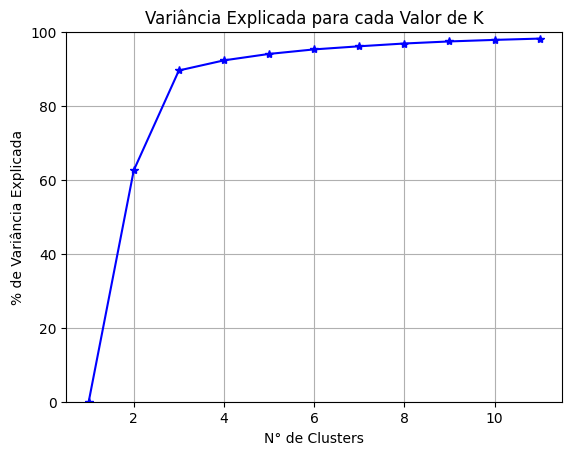

In [22]:
# Ajustando o centróide do cluster para cada modelo
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculando a distância euclidiana de cada ponto de dado para o centróide
k_euclid = [cdist(pca, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

# Soma dos quadrados das distâncias dentro do cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

# Soma total dos quadrados
soma_total = sum(pdist(pca)**2)/pca.shape[0]

# Soma dos quadrados entre clusters
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

# Curva de Elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, soma_quadrados_inter_cluster/soma_total * 100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('N° de Clusters')
plt.ylabel('% de Variância Explicada')
plt.title('Variância Explicada para cada Valor de K')

### Escolhendo um Valor de K inicial (igual a 8) para avaliação da Máquina Preditiva

In [23]:
# Criando um modelo com K = 8
modelo_v1 = KMeans(n_clusters = 8)
modelo_v1.fit(pca)

KMeans()

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html

#5° Avaliação da Máquina Preditiva

#### Avaliando a Máquina Preditiva V1 com k=8

In [24]:
# Obtém os valores mínimos e máximos e organiza o shape
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

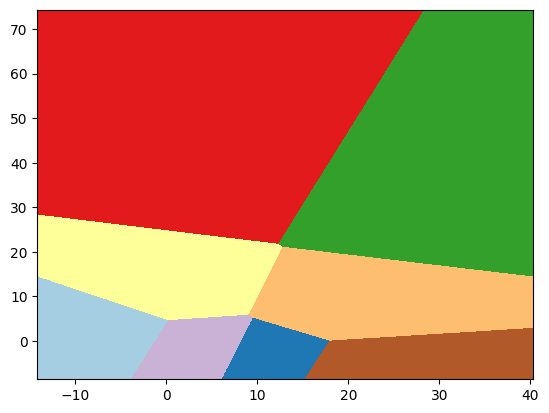

In [25]:
# Plot das áreas dos clusters
plt.figure(1)
plt.clf()
plt.imshow(Z,
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto',
           origin = 'lower')

In [26]:
# Métrica de avaliação para Clusterização
# O melhor valor é 1 e o pior valor é -1
?silhouette_score

In [27]:
# Silhouette Score
labels = modelo_v1.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.8071888934374821

#### Avaliando a Máquina Preditiva V2 com K=9

In [28]:
# Criando um modelo com K = 9
modelo_v2 = KMeans(n_clusters = 9)
modelo_v2.fit(pca)

KMeans(n_clusters=9)

In [29]:
# Silhouette Score
labels = modelo_v2.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.671249787096718

#### Avaliando a Máquina Preditiva V3 com K=10

In [30]:
# Criando um modelo com K = 10
modelo_v2 = KMeans(n_clusters = 10)
modelo_v2.fit(pca)

KMeans(n_clusters=10)

In [31]:
# Silhouette Score
labels = modelo_v2.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.6241523855451744

#### Avaliando a Máquina Preditiva V4 com K=11

In [32]:
# Criando um modelo com K = 11
modelo_v3 = KMeans(n_clusters = 11)
modelo_v3.fit(pca)

KMeans(n_clusters=11)

In [33]:
# Silhouette Score
labels = modelo_v3.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.6263749470709088

# Usando a Marcação dos Clusters da Máquina Preditiva Final



In [34]:
# Lista com nomes das colunas
names = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

In [38]:
# Incluindo o n° do cluster na base de clientes
cluster_map = pd.DataFrame(dataset, columns = names)
cluster_map['Global_active_power'] = pd.to_numeric(cluster_map['Global_active_power'])
cluster_map['cluster'] = modelo_v1.labels_

In [39]:
cluster_map

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,cluster
0,0.156,0.000,241.830,0.600,0.000,0.000,1.0,0
1,1.578,0.310,240.740,6.600,0.000,1.000,18.0,1
2,1.484,0.064,242.710,6.000,0.000,1.000,19.0,1
3,0.266,0.270,239.670,1.400,0.000,2.000,1.0,0
4,1.746,0.096,242.470,7.200,0.000,1.000,18.0,1
...,...,...,...,...,...,...,...,...
20487,1.788,0.214,241.040,7.400,0.000,0.000,18.0,1
20488,0.250,0.256,241.050,1.400,0.000,0.000,0.0,0
20489,1.966,0.348,243.420,8.200,2.000,0.000,19.0,1
20490,0.542,0.132,236.700,2.400,0.000,2.000,1.0,0


In [40]:
# Calcula a média de consumo de energia por cluster
cluster_map.groupby('cluster')['Global_active_power'].mean()

cluster
0    0.508764
1    1.820516
2    4.548575
3    3.424426
4    3.812255
5    1.112851
6    2.596444
7    2.372990
Name: Global_active_power, dtype: float64

# **Resumão**

1. Porque **PCA**:

Para acelerar o tempo de desenvolvimento (uso 2 componentes ao invés de 7 variáveis) A mesma informação das 7 variáveis compactadas em 2 componentes usando autovetores e autovalores...

2. Valor de **K**:

Não sabemos o melhor....Vamos usar uma range de valores

3. **Cluster_centers**:

São os Centróides dos quais se calculam a distância matemática de cada consumidor

4. **Métrica** de Avaliação da Máquina:

Usamos o Silhouete Score. Quanto mais próximo de 1, melhor.

5. **Resultado**:

O Grupo 2 tem maior consumo de energia.
Quais as principais diferenças entre os grupos que consomem mais energia?
Depois de criado o cluster poderia fazer previsão do consumo de energia do próximo período

Pode utilizar o cluster como variável de outra Máquina Preditiva que faz previsão de consumo otimizando a cadeia de distribuição e fornecimento de Energia.

A clusterização não é o FIm. Ela é o meio. Ela agrupa os dados. Depois vc toma decisões.
